In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 46 kB 1.9 MB/s 
     |████████████████████████████████| 186 kB 40.1 MB/s 
     |████████████████████████████████| 1.2 MB 26.3 MB/s 
     |████████████████████████████████| 56 kB 1.9 MB/s 
     |████████████████████████████████| 51 kB 203 kB/s 
Mounted at /content/gdrive


In [2]:
from fastai.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)

In [3]:
Path.BASE_PATH = path

In [4]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

### Data Preprocessing
- Preprocess the dataset for the language model
- Manually tokenize and numericalize the data
- Create batches for the model to read

In [5]:
text = " . ".join(line.strip() for line in lines)
text[:50]

'one . two . three . four . five . six . seven . ei'

In [6]:
# get the tokens by splitting on spaces
tokens = text.split()
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [7]:
vocab = list(set(tokens))
vocab[:10]

['one',
 'hundred',
 'twenty',
 'eleven',
 'fifty',
 'six',
 'forty',
 'five',
 'eighty',
 'seventy']

In [8]:
word2index = {word: i for i, word in enumerate(vocab)}
word2index['two']

24

In [9]:
num_tokens = [word2index[word] for word in tokens]
num_tokens[:10]

[0, 22, 24, 22, 25, 22, 18, 22, 7, 22]

In [10]:
len_tks = 6

for i in range(0,len_tks-4,3):
  print(i)

0


In [11]:
print(len(tokens))

63095


In [12]:
# want sequences of consecutive characters
seq_len = 16
seqs = [(torch.Tensor(num_tokens[i: i+seq_len]).long(), torch.Tensor(num_tokens[i+1:i+seq_len+1]).long()) for i in range(0,len(num_tokens)-seq_len-1, seq_len)]
seqs[:2]                                                                                         

[(tensor([ 0, 22, 24, 22, 25, 22, 18, 22,  7, 22,  5, 22, 23, 22, 13, 22]),
  tensor([22, 24, 22, 25, 22, 18, 22,  7, 22,  5, 22, 23, 22, 13, 22, 21])),
 (tensor([21, 22, 17, 22,  3, 22, 12, 22, 28, 22, 16, 22, 14, 22, 20, 22]),
  tensor([22, 17, 22,  3, 22, 12, 22, 28, 22, 16, 22, 14, 22, 20, 22, 15]))]

In [13]:
# want data in order
# (0, m, 2m, ..., )

def group_chunks(dset, bs):
  m = len(dset) // bs
  new_dset = []

  for i in range(m):
    new_dset += [dset[i + m*j] for j in range(bs)]
  return new_dset

In [14]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs), 
    group_chunks(seqs[cut:], bs), 
    bs=bs, drop_last=True, shuffle=False)

In [15]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 16]), torch.Size([64, 16]))

### Experiment with RNNs
- Write RNNs from scratch

In [16]:
class LMModel1(Module):
  def __init__(self, vocab_sz, n_hidden):
    self.i_h = nn.Embedding(vocab_sz, n_hidden)
    self.h_h = nn.Linear(n_hidden, n_hidden)
    self.h_o = nn.Linear(n_hidden, vocab_sz)
    self.h = 0
    self.relu = nn.ReLU()
  
  def forward(self, x):
    # print(x.shape)
    outs = []
    for i in range(x.shape[1]):
      # add the hidden state to the input to hidden state
      self.h = self.h + self.i_h(x[:, i])
      # compute new hidden state
      self.h = self.relu(self.h_h(self.h))
      # make a prediction for new character
      outs.append(self.h_o(self.h))

      
    self.h = self.h.detach()
    outs = torch.stack(outs, dim=1)
    # print(outs.shape)

    return outs
  
  
  def reset(self):
    self.h = 0

In [17]:
def flat_cross_entropy(inp, targ):
  # flatten the target from (bs, seq) -> (bs*seq)
  # accomodate by flattening inputs (bs, seq, vocab_sz) -> (bs*seq, vocab_sz)
  return F.cross_entropy(inp.view(bs*seq_len, -1), targ.view(-1))

In [18]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [19]:
print(len(vocab))

30


SuggestedLRs(valley=0.0014454397605732083)

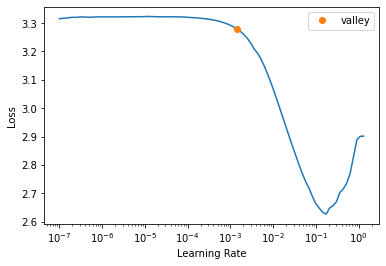

In [20]:
learn = Learner(dls, LMModel1(len(vocab), 64), loss_func=flat_cross_entropy,
                metrics=accuracy, cbs=ModelResetter)
learn.lr_find()

In [21]:
learn.fit_one_cycle(20, 0.0005)

epoch,train_loss,valid_loss,accuracy,time
0,3.294538,3.288750,0.062419,00:00
1,3.188219,3.089181,0.144124,00:00
2,2.799312,2.467369,0.366455,00:00
3,2.171992,1.892586,0.453695,00:00
4,1.771753,1.852661,0.466064,00:00
5,1.568759,1.778843,0.473958,00:00
6,1.449465,1.739035,0.473145,00:00
7,1.373855,1.725032,0.503662,00:00
8,1.314535,1.790236,0.498454,00:00
9,1.271651,1.704142,0.524414,00:00


### Multilayer RNN
- Experiment with multilayer RNNs
- Have a different hidden state in effect making the model deeper (more params to update)
- Make the multilayer RNN from scratch
- Make the multilayer RNN using pytorch

In [74]:
class LMModel2(Module):

  def __init__(self, vocab_sz, n_hidden, n_layers):
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.relu = nn.ReLU()
    # must create hidden state for each layer in the network
    self.h = torch.zeros(n_layers, bs, n_hidden)

    self.i_h = nn.Embedding(vocab_sz, n_hidden)
    self.rnn_layers = []
    # create the middle rnn layers according to n_layers
    for i in range(n_layers):
      self.rnn_layers.append(nn.Linear(n_hidden, n_hidden))
    self.h_o = nn.Linear(n_hidden, vocab_sz)


  def forward(self, x):
    outs = []

    # loop through the sequence of inputs
    for i in range(x.shape[1]):
      # update the hidden state for the first RNN layer
      self.h.data[0] = self.h.data[0] + self.i_h(x[:, i])

      # loop through multilayers and apply them
      for i, h_layer in enumerate(self.rnn_layers):
        if i == 0:
          # already dealt with input to first layer above, apply hidden layer
          self.h.data[i] = self.relu(h_layer(self.h.data[i]))

        else:
          # pass prev activations in
          self.h.data[i] = self.h.data[i] + self.h.data[i-1]
          # apply new RNN layer
          self.h.data[i] = self.relu(h_layer(self.h.data[i]))
      
      # at the end, go hidden to output on the last set of activations
      outs.append(self.h_o(self.h[-1]))

    # detach the gradients
    self.h = self.h.detach()

    return torch.stack(outs, dim=1)
  
  def reset(self):
    # reset the hidden state on epoch or validation
    # self.h = torch.zeros(self.n_layers, bs, self.n_hidden)
    self.h = torch.zeros_like(self.h)

In [75]:
learn = Learner(dls, LMModel2(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(8, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.316815,3.207514,0.115316,00:00
1,3.057730,2.902915,0.139486,00:00
2,2.906930,2.851313,0.139567,00:00
3,2.842726,2.839864,0.158447,00:00
4,2.816572,2.840768,0.156250,00:00
5,2.807096,2.844675,0.133708,00:00
6,2.804149,2.846586,0.130859,00:00
7,2.803239,2.846965,0.130859,00:00


## Realizations from above
- After writing the RNN code, I realized that it was not training
- You cannot index into a variable in pytorch and set it partially when requires grad; a work around would be needed for this
- If the indexing in pytorch did not require a work around, the previous model would have worked
- Try implementing multilayer rnn with pytorch now

In [80]:
# override the previous LMModel2 class
class LMModel2(Module):
  def __init__(self, vocab_sz, n_hidden, n_layers):
    self.i_h = nn.Embedding(vocab_sz, n_hidden)
    self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
    self.h_o = nn.Linear(n_hidden, vocab_sz)
    self.h = torch.zeros(n_layers, bs, n_hidden)

  
  def forward(self, x):
    inps = self.i_h(x)
    # this does all of the for loops and indexing to end with a final outs variable
    outs, hid = self.rnn(inps, self.h)
    self.h = self.h.detach()
    return self.h_o(outs)
  

  def reset(self):
    self.h.zero_()

In [81]:
learn = Learner(dls, LMModel2(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.051284,2.649105,0.434570,00:01
1,2.175310,1.813555,0.451986,00:01
2,1.730105,1.923177,0.310628,00:01
3,1.567270,1.920882,0.332845,00:01
4,1.477686,1.917347,0.365804,00:01
5,1.401953,1.906103,0.412191,00:01
6,1.327616,1.951426,0.434408,00:01
7,1.259548,1.958533,0.455566,00:01
8,1.206941,1.955413,0.464681,00:01
9,1.166636,1.971602,0.468424,00:01


In [88]:
learn.model.h_o.weight

Parameter containing:
tensor([[-0.0346,  0.3411,  0.1147,  ..., -0.0028,  0.2650, -0.1878],
        [-0.1974,  0.2108,  0.1868,  ...,  0.2328, -0.0865, -0.2514],
        [-0.1573, -0.1344, -0.1193,  ...,  0.1231, -0.1139, -0.2583],
        ...,
        [ 0.1765, -0.1864, -0.0462,  ..., -0.1489,  0.1038,  0.0881],
        [ 0.1313, -0.0993, -0.0919,  ..., -0.1330, -0.1156,  0.0079],
        [ 0.1888, -0.2344, -0.1772,  ..., -0.0435, -0.0884, -0.1011]], requires_grad=True)